In [1]:
import time
import os
import cv2
import matplotlib.pyplot as plt
from lib.utilities import *
import numpy as np
import pandas as pd
import datetime

# investigate probability of crossing controlling for distance to boundary
# (and size of barrel?)

In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
# data_dir = 'C:/Users/jjudg/Downloads/'
cell_type_prefix = 'scnn1a'
plt.rcParams.update({'font.size': 13})
#plt.rcParams['figure.figsize'] = [20, 12]

In [3]:
# work with latency data
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
csv_prefix = cell_type_prefix + '_all_slices-final.csv'

# Load reference data for all slices
reference_file = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/" + cell_type_prefix + "_catalog.csv"
reference_df = pd.read_csv(reference_file)
ref_cols = ['Age', 
          'Sex', 
          "Infusion", 
          'Stim (uA)']

# load the all-data CSV dir
df = pd.read_csv(data_dir + csv_prefix)
df = pd.DataFrame(df)
df

,Date,Slice/Loc/Rec,Slice Edge,Most Medial Barrel,Medial Dir,Slice Location,Stim Location,Actual Stim Time (ms),Stim Barrel,L4 barrel 1 Latency,...,Distance to Barrel 2,Distance to Layer n1,Distance to Layer n2,Distance to Barrel A,Distance to Barrel B,Distance to Layer nA,Distance to Layer nB,Actual latency barrel 1,Actual latency barrel 2,Actual latency barrel 3
0,2/8/2023,02_01_02,NaN,NaN,NaN,NaN,L4,48.4226,NaN,47.7369,...,NaN,NaN,NaN,215.228351,174.000000,180.093736,191.535134,NaN,NaN,NaN
1,2/10/2023,04_01_07,NaN,NaN,NaN,NaN,L4,48.4429,2.0,52.7236,...,NaN,NaN,NaN,151.086327,213.337695,149.891961,202.354632,4.2807,1.5076,NaN
2,2/14/2023,02_01_01,NaN,NaN,NaN,NaN,L4,48.4645,3.0,47.5447,...,NaN,NaN,NaN,198.974687,232.730513,132.022414,229.523778,NaN,NaN,1.5173
3,2/14/2023,03_01_03,NaN,NaN,NaN,NaN,L4,48.4195,2.0,51.1559,...,NaN,NaN,NaN,228.000000,162.000000,159.011987,199.155462,NaN,1.9055,2.8317
4,2/28/2023,02_01_01,NaN,NaN,NaN,NaN,L5,48.4151,3.0,50.3009,...,NaN,NaN,NaN,44.346286,328.107622,171.794234,154.795349,NaN,2.4255,0.9306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,10/19/2023,05_06_02,down/right,1.0,down/left,Anterior,L2/3,48.4228,1.0,52.5402,...,NaN,NaN,NaN,24.997803,181.431965,314.744870,103.797327,4.1174,2.8533,NaN
170,10/19/2023,06_01_01,down,3.0,right,Posterior,L4,48.5290,2.0,50.6833,...,NaN,NaN,NaN,118.898651,202.376373,288.667605,69.296479,2.1543,1.8040,NaN
171,10/19/2023,06_02_02,down,3.0,right,Posterior,L4,48.4103,3.0,50.3022,...,NaN,NaN,NaN,151.005549,215.305522,75.027164,306.897033,1.8919,2.6575,3.6943
172,10/19/2023,06_03_01,down,3.0,right,Posterior,L2/3,48.5911,3.0,52.3050,...,NaN,NaN,NaN,322.923386,22.555042,70.935246,350.093066,3.7139,3.1466,NaN


In [4]:
# Repeat analysis (originally done in ROI-to-CSVdata.ipynb) but split by Rostral / caudal 
data = {}
snr_factor_cutoff_signal = 2.0
snr_cutoff_signal = 3.0
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    data[stim_loc] = {}
    
    # Caudal and Rostral Combined
    print("Barrel pairs in", stim_loc)
    # count number of barrel pairs with no signal crossing
    df2 = df[df['Stim Location'].str.contains(stim_loc)]

    # count number of barrel pairs with no signal crossing
    n_barrel_no_cross = len(df2[df2['# no crossings 2/3'] > 0])
    n_barrel_no_cross += len(df2[df2['# no crossings 1/2'] > 0])
    print("\t", n_barrel_no_cross, "no crossing out of", len(df2) * 2, "in layer", stim_loc)

    # count number of barrel pairs with signal crossing
    n_barrel_cross = len(df2[df2['# crossings 2/3'] > 0])
    n_barrel_cross += len(df2[df2['# crossings 1/2'] > 0])
    print("\t", n_barrel_cross, "crossing out of", len(df2) * 2, "in layer", stim_loc)

    # count number of barrel pairs with no signal
    n_barrel_none = len(df2) * 2 - n_barrel_cross - n_barrel_no_cross
    print("\t", n_barrel_none, "no signal out of", len(df2) * 2, "in layer", stim_loc)

    data[stim_loc]['n_barrel_no_cross'] = n_barrel_no_cross
    data[stim_loc]['n_barrel_cross'] = n_barrel_cross
    data[stim_loc]['n_barrel_none'] = n_barrel_none
    data[stim_loc]['total'] = len(df2) * 2 - n_barrel_none
"""
print("\nCaudal vs Rostral divided")
# Now Caudal vs Rostral
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    for slice_loc in ['Anterior', 'Posterior']:
        df2_sl = df2[df2['Slice Location'] == slice_loc]
        
        data[stim_loc][slice_loc] = {}

        print(slice_loc + " barrel pairs in", stim_loc)
        # count number of barrel pairs with no signal crossing
        n_barrel_no_cross = len(df2_sl[(df2_sl['L4 barrel 1 SNR'] < snr_cutoff_signal) & 
                                   (df2_sl['L4 barrel 2 SNR'] > snr_cutoff_signal)])
        n_barrel_no_cross += len(df2_sl[(df2_sl['L4 barrel 2 SNR'] < snr_cutoff_signal) & 
                                    (df2_sl['L4 barrel 1 SNR'] > snr_cutoff_signal)])
        n_barrel_no_cross += len(df2_sl[(df2_sl['L4 barrel 2 SNR'] < snr_cutoff_signal) & 
                                    (df2_sl['L4 barrel 3 SNR'] > snr_cutoff_signal)])
        n_barrel_no_cross += len(df2_sl[(df2_sl['L4 barrel 3 SNR'] < snr_cutoff_signal) & 
                                    (df2_sl['L4 barrel 2 SNR'] > snr_cutoff_signal)])
        print("\t", n_barrel_no_cross, "no crossing out of", len(df2_sl) * 2, "in layer", stim_loc)

        # count number of barrel pairs with signal crossing
        n_barrel_cross = len(df2_sl[(df2_sl['L4 barrel 1 SNR'] > snr_cutoff_signal) & 
                                (df2_sl['L4 barrel 2 SNR'] > snr_cutoff_signal)])
        n_barrel_cross += len(df2_sl[(df2_sl['L4 barrel 2 SNR'] > snr_cutoff_signal) & 
                                 (df2_sl['L4 barrel 3 SNR'] > snr_cutoff_signal)])
        print("\t", n_barrel_cross, "crossing out of", len(df2_sl) * 2, "in layer", stim_loc)

        # count number of barrel pairs with no signal
        n_barrel_none = len(df2_sl[(df2_sl['L4 barrel 1 SNR'] < snr_cutoff_signal) & 
                                (df2_sl['L4 barrel 2 SNR'] < snr_cutoff_signal)])
        n_barrel_none += len(df2_sl[(df2_sl['L4 barrel 2 SNR'] < snr_cutoff_signal) & 
                                 (df2_sl['L4 barrel 3 SNR'] < snr_cutoff_signal)])
        print("\t", n_barrel_none, "no signal out of", len(df2_sl) * 2, "in layer", stim_loc)
        
        data[stim_loc][slice_loc]['n_barrel_no_cross'] = n_barrel_no_cross
        data[stim_loc][slice_loc]['n_barrel_cross'] = n_barrel_cross
        data[stim_loc][slice_loc]['n_barrel_none'] = n_barrel_none
        data[stim_loc][slice_loc]['total'] = len(df2_sl) * 2 - n_barrel_none
"""

Barrel pairs in L2/3
	 19 no crossing out of 120 in layer L2/3
	 48 crossing out of 120 in layer L2/3
	 53 no signal out of 120 in layer L2/3
Barrel pairs in L4
	 69 no crossing out of 196 in layer L4
	 35 crossing out of 196 in layer L4
	 92 no signal out of 196 in layer L4
Barrel pairs in L5
	 10 no crossing out of 28 in layer L5
	 7 crossing out of 28 in layer L5
	 11 no signal out of 28 in layer L5


'\nprint("\nCaudal vs Rostral divided")\n# Now Caudal vs Rostral\nfor stim_loc in [\'L2/3\', \'L4\', \'L5\']:\n    df2 = df[df[\'Stim Location\'].str.contains(stim_loc)]\n    for slice_loc in [\'Anterior\', \'Posterior\']:\n        df2_sl = df2[df2[\'Slice Location\'] == slice_loc]\n        \n        data[stim_loc][slice_loc] = {}\n\n        print(slice_loc + " barrel pairs in", stim_loc)\n        # count number of barrel pairs with no signal crossing\n        n_barrel_no_cross = len(df2_sl[(df2_sl[\'L4 barrel 1 SNR\'] < snr_cutoff_signal) & \n                                   (df2_sl[\'L4 barrel 2 SNR\'] > snr_cutoff_signal)])\n        n_barrel_no_cross += len(df2_sl[(df2_sl[\'L4 barrel 2 SNR\'] < snr_cutoff_signal) & \n                                    (df2_sl[\'L4 barrel 1 SNR\'] > snr_cutoff_signal)])\n        n_barrel_no_cross += len(df2_sl[(df2_sl[\'L4 barrel 2 SNR\'] < snr_cutoff_signal) & \n                                    (df2_sl[\'L4 barrel 3 SNR\'] > snr_cutoff_signal)

In [5]:
# Scatter plot: # crossings per (binned) distance from boundary.
data = {}
snr_factor_cutoff_signal = 2.0
snr_cutoff_signal = 3.0
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    data[stim_loc] = {}
    
    # Caudal and Rostral Combined
    print("Barrel pairs in", stim_loc)
    # count number of barrel pairs with no signal crossing
    df2_a = df2[(df2['L4 barrel 1 SNR'] * snr_factor_cutoff_signal) < 
                               df2['L4 barrel 2 SNR']]
    
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    print("Barrel pairs in", stim_loc)
    # count number of barrel pairs with no signal crossing
    n_barrel_no_cross = len(df2[df2['# no crossings 2/3'] > 0])
    n_barrel_no_cross += len(df2[df2['# no crossings 1/2'] > 0])
    print("\t", n_barrel_no_cross, "no crossing out of", len(df2) * 2, "in layer", stim_loc)

    # count number of barrel pairs with signal crossing
    n_barrel_cross = len(df2[df2['# crossings 2/3'] > 0])
    n_barrel_cross += len(df2[df2['# crossings 1/2'] > 0])
    print("\t", n_barrel_cross, "crossing out of", len(df2) * 2, "in layer", stim_loc)

    # count number of barrel pairs with no signal
    n_barrel_none = len(df2) * 2 - n_barrel_cross - n_barrel_no_cross
    print("\t", n_barrel_none, "no signal out of", len(df2) * 2, "in layer", stim_loc)

    data[stim_loc]['n_barrel_no_cross'] = n_barrel_no_cross
    data[stim_loc]['n_barrel_cross'] = n_barrel_cross
    data[stim_loc]['n_barrel_none'] = n_barrel_none
    data[stim_loc]['total'] = len(df2) * 2 - n_barrel_none

Barrel pairs in L2/3
Barrel pairs in L2/3
	 19 no crossing out of 120 in layer L2/3
	 48 crossing out of 120 in layer L2/3
	 53 no signal out of 120 in layer L2/3
Barrel pairs in L4
Barrel pairs in L4
	 69 no crossing out of 196 in layer L4
	 35 crossing out of 196 in layer L4
	 92 no signal out of 196 in layer L4
Barrel pairs in L5
Barrel pairs in L5
	 10 no crossing out of 28 in layer L5
	 7 crossing out of 28 in layer L5
	 11 no signal out of 28 in layer L5


{'# no crossing': [6.505819318717424, 7.987138329728918, 18.601633295108112], '# crossing': [10.340601836232102, 5.6885382529804, 15.563243006262297]}


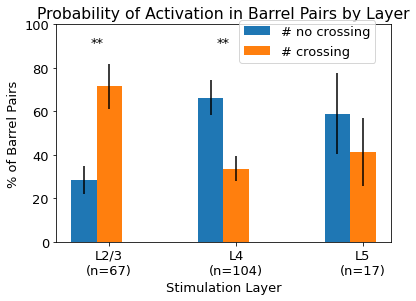

In [14]:
plt.clf()
i = 0
tick_labels = []
colors = {"# no crossing": 'tab:blue', "# crossing": 'tab:orange'}
# in format # no crossing, # crossing, # no signal; l2/3, L4, L5

length_of_previous_sl = i

n_L23 = data['L2/3']['total']
n_L4 = data['L4']['total']
n_L5 = data['L5']['total']

all_layers = []
totals = []
if n_L23 > 0:
    all_layers.append('L2/3')
    totals.append(n_L23)
if n_L4 > 0:
    all_layers.append('L4')
    totals.append(n_L4)
if n_L5 > 0:
    all_layers.append('L5')
    totals.append(n_L5)


# in columns L23, L4, L5
crossing_data = {
    "# no crossing": [data[x]['n_barrel_no_cross'] for x in all_layers],
    '# crossing': [data[x]['n_barrel_cross'] for x in all_layers],
    #'# no signal': [data[x]['n_barrel_none'] for x in ['L2/3', 'L4', 'L5']],
    #"L2/3": [3, 17, 30],
    #"L4": [38, 20, 30],
    #"L5": [8, 13, 1]
}
errbars = {}
for k in crossing_data:
    errbars[k] = [np.sqrt(x) for x in crossing_data[k]]
    for j in range(len(totals)):
        crossing_data[k][j] /= totals[j] / 100
        errbars[k][j] /= totals[j] / 100

labels = [x for x in crossing_data.keys()]
tick_labels += [all_layers[j] + "\n(n="+str(totals[j]) + ")"
                            for j in range(len(all_layers))]

print(errbars)
    
##########################
for nm in crossing_data:
    x = np.arange(len(all_layers))
    # else:
    plt.bar(x + (i-1) * 0.2, 
        crossing_data[nm],
        0.2,
        label=(nm if length_of_previous_sl == 0 else None),
        color=colors[nm])
    plt.errorbar(x + (i-1) * 0.2, 
                crossing_data[nm],
                yerr=errbars[nm],
                fmt='none',
                color='black')
    i += 1

# plt.title("Probability of Activation in Barrel Pairs by Layer")
plt.xlabel("Stimulation Layer")
plt.ylabel("% of Barrel Pairs")
#plt.xticks(rotation='vertical')
plt.xticks(np.arange(len(tick_labels)), tick_labels)
plt.legend(bbox_to_anchor=(0.75, 1.05), loc='upper center')
plt.savefig(data_dir + "results_count_sept2023.png")
plt.annotate("**", (-0.15, 90))
plt.annotate("**", (0.85, 90))
plt.ylim(0, 100)
plt.show()

In [7]:
plt.clf()
i = 0
length_of_previous_sl = 0
tick_labels = []
colors = {"# no crossing": 'tab:blue', "# crossing": 'tab:orange'}
# in format # no crossing, # crossing, # no signal; l2/3, L4, L5
for sl in ['Anterior', 'Posterior']:
    
    length_of_previous_sl = i
    
    n_L23 = data['L2/3'][sl]['total']
    n_L4 = data['L4'][sl]['total']
    n_L5 = data['L5'][sl]['total']
    
    all_layers = []
    totals = []
    if n_L23 > 0:
        pass
        #all_layers.append('L2/3')
        #totals.append(n_L23)
    if n_L4 > 0:
        all_layers.append('L4')
        totals.append(n_L4)
    if n_L5 > 0:
        pass
        #all_layers.append('L5')
        #totals.append(n_L5)
    
    
    # in columns L23, L4, L5
    crossing_data = {
        "# no crossing": [data[x][sl]['n_barrel_no_cross'] for x in all_layers],
        '# crossing': [data[x][sl]['n_barrel_cross'] for x in all_layers],
        #'# no signal': [data[x][sl]['n_barrel_none'] for x in ['L2/3', 'L4', 'L5']],
        #"L2/3": [3, 17, 30],
        #"L4": [38, 20, 30],
        #"L5": [8, 13, 1]
    }
    errbars = {}
    for k in crossing_data:
        errbars[k] = [np.sqrt(x) for x in crossing_data[k]]
        for j in range(len(totals)):
            crossing_data[k][j] /= totals[j] / 100
            errbars[k][j] /= totals[j] / 100
            
    labels = [x for x in crossing_data.keys()]
    tick_labels += [all_layers[j] + "\n" + ("Rostral" if sl == "Anterior" else "Caudal") + "\n(n="+str(totals[j]) + ")"
                                for j in range(len(all_layers))]

    # plot this as bars 
    for nm in crossing_data:
        x = np.arange(length_of_previous_sl, len(all_layers) + length_of_previous_sl)
        '''        if i == length_of_previous_sl + 1:  # first iter of this sl
            plt.bar(x + (i-1) * 0.2, 
                    crossing_data[nm],
                    0.2,
                    label=nm,
                    tick_label=tick_labels)
                                #'L2/3\n(n='+str(n_L23)+')', 
                                #'L4\n(n='+str(n_L4)+')', 
                                #'L5\n(n='+str(n_L5)+')'])'''
        # else:
        plt.bar(x + (i-1) * 0.2, 
            crossing_data[nm],
            0.2,
            label=(nm if length_of_previous_sl == 0 else None),
            color=colors[nm])
        plt.errorbar(x + (i-1) * 0.2, 
                    crossing_data[nm],
                    yerr=errbars[nm],
                    fmt='none',
                    color='black')
        i += 1
    
plt.title("Frequency of Signal Pattern in Barrel Pairs by Caudal-Rostral Position")
plt.xlabel("Stimulation Layer")
plt.ylabel("% of Barrel Pairs")
plt.xticks(np.arange(len(tick_labels)), tick_labels)
#plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(0.55, .95), loc='upper center')
plt.savefig(data_dir + "results_count_prelim_" + str(datetime.date.today()) + ".png", bbox_inches="tight")
plt.show()

KeyError: 'Anterior'

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot latency spreads, separated by layer

df['abs(delta 1)'] = np.abs(df['Delta latency 1 (barrel 1 - barrel 2)'])
df['abs(delta 2)'] = np.abs(df['Delta latency 2 (barrel 3 - barrel 2)'])


plt.clf()
i = 1
xtick_labels = []
df_datasets = []
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    
    df2_ant = df2[df2['Slice Location'] == "Anterior"]
    dfd1_ant = df2_ant['abs(delta 1)'].dropna()
    dfd2_ant = df2_ant['abs(delta 2)'].dropna()
    
    df2_post = df2[df2['Slice Location'] == "Posterior"]
    dfd1_post = df2_post['abs(delta 1)'].dropna()
    dfd2_post = df2_post['abs(delta 2)'].dropna()
    
    dfds_ant = np.concatenate([dfd1_ant, dfd2_ant])
    dfds_post = np.concatenate([dfd1_post, dfd2_post])
    
    if len(dfds_ant) > 0:
        print("Latency between anterior (rostral) barrel pairs in", stim_loc)
        print("\t", 
              str(np.mean(dfds_ant))[:5], 
              "+/-", 
              str(np.std(dfds_ant))[:5], 
              "(n =", 
              str(len(dfds_ant)) + ")")
        print("\t", dfds_ant)
    if len(dfds_post) > 0:
        print("Latency between posterior (caudal) barrel pairs in", stim_loc)
        print("\t", 
              str(np.mean(dfds_post))[:5], 
              "+/-", 
              str(np.std(dfds_post))[:5], 
              "(n =", 
              str(len(dfds_post)) + ")")
        print("\t", dfds_post)
    if len(dfds_post) < 1 and len(dfds_ant) < 1:
        continue
    
    jittered_xs_1 = np.random.normal(i, 0.04, dfds_ant.shape[0])
    jittered_xs_2 = np.random.normal(i+1, 0.04, dfds_post.shape[0])
    plt.scatter(jittered_xs_1, dfds_ant, alpha=0.5, color='blue')
    plt.scatter(jittered_xs_2, dfds_post, alpha=0.5, color='green')

    xtick_labels.append(stim_loc + "\nRostral\n(n=" + str(len(dfds_ant)) +")")
    xtick_labels.append(stim_loc + "\nCaudal\n(n=" + str(len(dfds_post)) +")")
    df_datasets.append(dfds_ant)
    df_datasets.append(dfds_post)
    i += 2

plt.boxplot(df_datasets)
plt.xticks(range(1, len(xtick_labels)+1), xtick_labels)
plt.title("Latency of L4 Barrel Pair Crossings")
plt.xlabel("Stimulation Layer")
plt.ylabel("Latency (ms)")
plt.savefig(data_dir + cell_type_prefix + "_results_latency_prelim_" + str(datetime.date.today()) +".png", bbox_inches="tight")
plt.show()

In [ ]:
# plot latency spreads vs dist from barrel scatter

df['abs(delta 1)'] = np.abs(df['Delta latency 1 (barrel 1 - barrel 2)'])
df['abs(delta 2)'] = np.abs(df['Delta latency 2 (barrel 3 - barrel 2)'])



plt.clf()
i = 1
xtick_labels = []
df_datasets = []
colorset = {
    "L2/3": "blue",
    "L4": "green",
    "L5": "orange"
}
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]

    dfd1_post = df2.dropna(subset=['abs(delta 1)', 'Distance to Barrel A'])
    dfd2_post = df2.dropna(subset=['abs(delta 2)', 'Distance to Barrel B'])
    
    dfds_post = np.concatenate([dfd1_post, dfd2_post])

    """    if len(dfds_post) > 0:
        print("Latency between posterior (caudal) barrel pairs in", stim_loc)
        print("\t", 
              str(np.mean(dfds_post))[:5], 
              "+/-", 
              str(np.std(dfds_post))[:5], 
              "(n =", 
              str(len(dfds_post)) + ")")
        print("\t", dfds_post)"""
    
    plt.scatter(dfd1_post['Distance to Barrel A'], dfd1_post['abs(delta 1)'], alpha=0.5, color=colorset[stim_loc])
    plt.scatter(dfd2_post['Distance to Barrel B'], dfd2_post['abs(delta 2)'], alpha=0.5, color=colorset[stim_loc])

    # xtick_labels.append(stim_loc + "\nCaudal\n(n=" + str(len(dfds_post)) +")")
    df_datasets.append(dfds_post)
    i += 2

plt.xticks(range(1, len(xtick_labels)+1), xtick_labels)
plt.title("Latency of L4 Barrel Pair Crossings")
plt.xlabel("Distance from Barrel Boundary Crossed (um)")
plt.ylabel("Latency (ms)")
plt.savefig(data_dir + cell_type_prefix + "_results_latency_prelim_" + str(datetime.date.today()) +".png", bbox_inches="tight")
plt.show()